In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
%load_ext autoreload

In [3]:
%load_ext line_profiler

In [4]:
%autoreload 2

In [5]:
import math
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
import scipy 

In [6]:
import statsmodels.api as sm

In [9]:
from datahandling import DataHandler
from preprocessing import Preprocessor, Standardizer

## Importing data

In [10]:
raw_df = DataHandler().read()

## Checking for discontinuities of bad range in data

In [12]:
for (Id, date), daily_data in raw_df.groupby(["Id", pd.Grouper(level=0, freq='1D')]):
    d = daily_data
    if d.index[0].time() != dt.time(9, 45):
        print(f"id {Id} has starts late ({d.index[0].time()}) on day {date}")
        break
    if d.index[-1].time() != dt.time(16, 0):
         print(f"id {Id} has ends early ({d.index[-1].time()}) on day {date}")
            
    if (d.index != pd.date_range(start=d.index[0], end=d.index[-1], freq='15T', inclusive="both")).any():
        print(f"id {Id} has discontinuous data on day {date}")
        break
        
print("No bad data found")

No bad data found


In [ ]:
# => we can use index values as there is no discontinuities

## Checking matching data between daily and intraday

In [24]:
last_data = raw_df.groupby(["Id", pd.Grouper(level=0, freq="D")]).last()

In [31]:
last_data

CumReturnResid  CumReturnRaw  CumVolume  \
Id                                                                           
BBG000B9WH86           2010-01-04       -0.000919      0.032249   25160630   
                       2010-01-05       -0.037940     -0.031241   48945660   
                       2010-01-06        0.021264      0.050234   44739384   
                       2010-01-07       -0.018720     -0.020077   37071020   
                       2010-01-08       -0.002510      0.024103   32271728   
...                                           ...           ...        ...   
GEN_EQ0140919900001000 2011-01-12        0.004308      0.005457    1978935   
                       2011-01-13        0.007952      0.006559    1865174   
                       2011-01-14        0.002274      0.005392    1396973   
                       2011-01-18        0.003268      0.005363    1430620   
                       2011-01-19       -0.000118     -0.001779    1358290   

                                  SYMBOL   MIC  FREE_FLOAT_PERCENTAGE  \
Id                                                                      
BBG000B9WH86           2010-01-04     AA  XNYS                99.7169   
                       2010-01-05     AA  XNYS                99.7170   
                       2010-01-06     AA  XNYS                99.7170   
                       2010-01-07     AA  XNYS                99.7170   
                       2010-01-08     AA  XNYS                99.7170   
...                                  ...   ...                    ...   
GEN_EQ0140919900001000 2011-01-12    PGN  XNYS                99.7662   
                       2011-01-13    PGN  XNYS                99.7662   
                       2011-01-14    PGN  XNYS                99.7662   
                       2011-01-18    PGN  XNYS                99.7662   
                       2011-01-19    PGN  XNYS                99.7662   

                                   EST_VOL       MDV_63   Open    High    Low  \
Id                                                                              
BBG000B9WH86           2010-01-04  0.17017  392090530.0  16.47  16.890  16.40   
                       2010-01-05  0.18214  392090530.0  16.83  16.850  16.03   
                       2010-01-06  0.18960  392090530.0  16.31  17.060  16.26   
                       2010-01-07  0.19430  392090530.0  16.52  16.660  16.30   
                       2010-01-08  0.20632  392090530.0  16.46  17.020  16.45   
...                                    ...          ...    ...     ...    ...   
GEN_EQ0140919900001000 2011-01-12  0.07674   63214480.0  43.94  44.275  43.93   
                       2011-01-13  0.07198   63598716.0  44.20  44.550  44.20   
                       2011-01-14  0.07388   63598716.0  44.41  44.830  44.26   
                       2011-01-18  0.06739   63598716.0  44.74  45.000  44.64   
                       2011-01-19  0.07528   63598716.0  44.95  45.050  44.85   

                                   Close      Volume  PxAdjFactor  \
Id                                                                  
BBG000B9WH86           2010-01-04  16.65  25872368.0     1.059996   
                       2010-01-05  16.13  49862200.0     1.059996   
                       2010-01-06  16.97  46703668.0     1.059996   
                       2010-01-07  16.61  38641508.0     1.059996   
                       2010-01-08  17.02  33081926.0     1.059996   
...                                  ...         ...          ...   
GEN_EQ0140919900001000 2011-01-12  44.24   2064663.0     1.218775   
                       2011-01-13  44.52   1962341.0     1.218775   
                       2011-01-14  44.73   1543797.0     1.218775   
                       2011-01-18  44.96   1534524.0     1.218775   
                       2011-01-19  44.90   1499454.0     1.218775   

                                   SharesAdjFactor  DailyReturn  
Id                                                  

In [52]:
last_data["DailyReturn"] =  (last_data["Close"] * last_data["PxAdjFactor"]).groupby("Id").pct_change()


In [56]:
last_data["ReturnError"] = ((last_data["CumReturnRaw"] - last_data["DailyReturn"]).abs() / last_data["DailyReturn"].abs()).clip(-1, 1)


In [57]:
last_data["VolumeError"] = ((last_data["CumVolume"] - last_data["Volume"]).abs() / last_data["Volume"]).clip(-1, 1)

array([[<Axes: title={'center': 'ReturnError'}>,
        <Axes: title={'center': 'VolumeError'}>]], dtype=object)

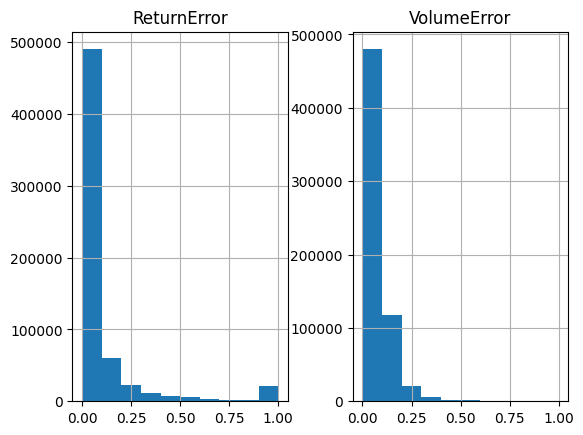

In [58]:
last_data[["ReturnError", "VolumeError"]].hist()

array([[<Axes: title={'center': 'ReturnError'}>,
        <Axes: title={'center': 'VolumeError'}>]], dtype=object)

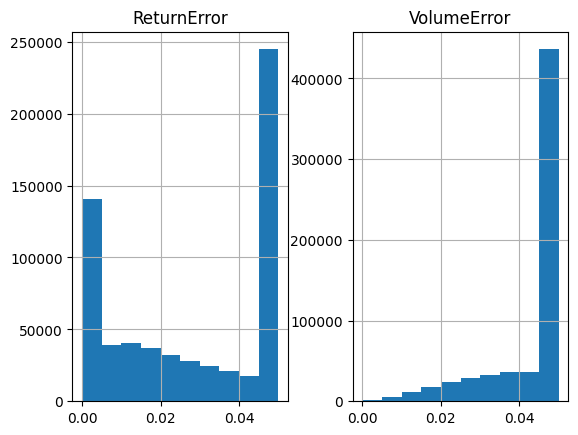

In [61]:
last_data[["ReturnError", "VolumeError"]].clip(0, 0.05).hist()

## Checking Turnover

In [89]:
daily_ids = raw_df.groupby(pd.Grouper(level=0, freq="D"))["Id"].unique().to_frame()
daily_ids = daily_ids[daily_ids.apply(lambda x: x.values[0].shape[0], axis=1)>0]
daily_ids["TomorrowsID"] = daily_ids.shift(-1)
daily_ids.drop(daily_ids.tail(1).index, inplace=True)
daily_ids

,Id,TomorrowsID
2010-01-04,"[BBG000MQ1SN9, BBG000BBCQD7, BBG000BBB3K1, BBG...","[BBG000MQ1SN9, BBG000BBB3K1, BBG000BNMHS4, BBG..."
2010-01-05,"[BBG000MQ1SN9, BBG000BBB3K1, BBG000BNMHS4, BBG...","[BBG000BJNGN9, BBG000CPHYL4, BBG000MQ1SN9, BBG..."
2010-01-06,"[BBG000BJNGN9, BBG000CPHYL4, BBG000MQ1SN9, BBG...","[BBG000BJNGN9, BBG000BBCQD7, BBG000MQ1SN9, BBG..."
2010-01-07,"[BBG000BJNGN9, BBG000BBCQD7, BBG000MQ1SN9, BBG...","[BBG000C04224, BBG000BC9938, BBG000BBCQD7, BBG..."
2010-01-08,"[BBG000C04224, BBG000BC9938, BBG000BBCQD7, BBG...","[BBG000BJNGN9, BBG000BR1W32, BBG000BBB3K1, BBG..."
...,...,...
2014-12-23,"[BBG000R8ZVD1, BBG000BGFZR8, BBG000BF3NZ1, BBG...","[BBG000BQG2C4, BBG000R8ZVD1, BBG000BGFZR8, BBG..."
2014-12-24,"[BBG000BQG2C4, BBG000R8ZVD1, BBG000BGFZR8, BBG...","[BBG000BFVXX0, BBG000BQG2C4, BBG000R8ZVD1, BBG..."
2014-12-26,"[BBG000BFVXX0, BBG000BQG2C4, BBG000R8ZVD1, BBG...","[BBG000BB38Q3, BBG000BQG2C4, BBG000BFVXX0, BBG..."
2014-12-29,"[BBG000BB38Q3, BBG000BQG2C4, BBG000BFVXX0, BBG...","[BBG000BQD1J2, BBG000BQG2C4, BBG000BFVXX0, BBG..."


In [92]:
compute_changes = lambda row: np.concatenate([np.setdiff1d(row["Id"], row["TomorrowsID"]), np.setdiff1d(row["TomorrowsID"],row["Id"])])

In [93]:
daily_ids["Changes"] = daily_ids.apply(compute_changes, axis=1)
daily_ids["Turnover"] = daily_ids["Changes"].apply(len)/daily_ids["Id"].apply(len)
daily_ids

,Id,TomorrowsID,Changes,Turnover
2010-01-04,"[BBG000MQ1SN9, BBG000BBCQD7, BBG000BBB3K1, BBG...","[BBG000MQ1SN9, BBG000BBB3K1, BBG000BNMHS4, BBG...","[BBG000BBCQD7, GEN_EQ0010168800001000]",0.004
2010-01-05,"[BBG000MQ1SN9, BBG000BBB3K1, BBG000BNMHS4, BBG...","[BBG000BJNGN9, BBG000CPHYL4, BBG000MQ1SN9, BBG...","[BBG000BBB3K1, GEN_EQ0010168800001000, BBG000B...",0.008
2010-01-06,"[BBG000BJNGN9, BBG000CPHYL4, BBG000MQ1SN9, BBG...","[BBG000BJNGN9, BBG000BBCQD7, BBG000MQ1SN9, BBG...","[BBG000C23PB0, BBG000JF5CV9, BBG000BBB3K1, BBG...",0.008
2010-01-07,"[BBG000BJNGN9, BBG000BBCQD7, BBG000MQ1SN9, BBG...","[BBG000C04224, BBG000BC9938, BBG000BBCQD7, BBG...","[BBG000BJNGN9, BBG000BNMHS4, BBG000BC9938, BBG...",0.008
2010-01-08,"[BBG000C04224, BBG000BC9938, BBG000BBCQD7, BBG...","[BBG000BJNGN9, BBG000BR1W32, BBG000BBB3K1, BBG...","[BBG000BC9938, BBG000C04224, BBG000CPHYL4, BBG...",0.012
...,...,...,...,...
2014-12-23,"[BBG000R8ZVD1, BBG000BGFZR8, BBG000BF3NZ1, BBG...","[BBG000BQG2C4, BBG000R8ZVD1, BBG000BGFZR8, BBG...","[BBG000BR37X2, BBG000BQG2C4]",0.004
2014-12-24,"[BBG000BQG2C4, BBG000R8ZVD1, BBG000BGFZR8, BBG...","[BBG000BFVXX0, BBG000BQG2C4, BBG000R8ZVD1, BBG...","[BBG000BVN235, BBG000BFVXX0]",0.004
2014-12-26,"[BBG000BFVXX0, BBG000BQG2C4, BBG000R8ZVD1, BBG...","[BBG000BB38Q3, BBG000BQG2C4, BBG000BFVXX0, BBG...","[BBG000BGFZR8, BBG000BB38Q3]",0.004
2014-12-29,"[BBG000BB38Q3, BBG000BQG2C4, BBG000BFVXX0, BBG...","[BBG000BQD1J2, BBG000BQG2C4, BBG000BFVXX0, BBG...","[BBG000BB38Q3, BBG000BQD1J2]",0.004


<Axes: >

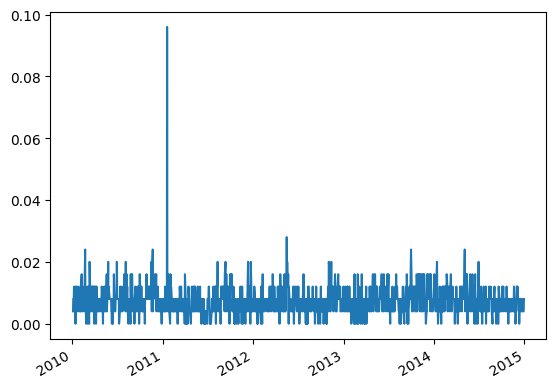

In [94]:
daily_ids["Turnover"].plot()


## Checking Preprocessor

In [95]:
raw_df

,Id,CumReturnResid,CumReturnRaw,CumVolume,SYMBOL,MIC,FREE_FLOAT_PERCENTAGE,EST_VOL,MDV_63,Open,High,Low,Close,Volume,PxAdjFactor,SharesAdjFactor
2010-01-04 09:45:00,BBG000MQ1SN9,0.002070,0.012778,43347,DVA,XNYS,99.6464,0.13074,4.383275e+07,59.12,60.05,59.09,59.92,955120.0,1.000000,1.000000
2010-01-04 09:45:00,BBG000BBCQD7,-0.012105,0.007787,229661,SLM,XNYS,99.1117,0.31610,4.409296e+07,11.45,11.72,11.32,11.54,2566745.0,1.000000,1.000000
2010-01-04 09:45:00,BBG000BBB3K1,-0.001020,0.001321,62697,RAI,XNYS,57.7643,0.11253,7.588626e+07,53.33,53.52,53.00,53.24,812905.0,1.160364,1.000000
2010-01-04 09:45:00,BBG000BNMHS4,0.012179,0.025810,47650,MAN,XNYS,99.3401,0.18568,4.413393e+07,54.94,56.58,54.78,56.41,1108030.0,1.034430,1.000000
2010-01-04 09:45:00,BBG000C23PB0,0.003520,0.008454,239259,SAI,XNYS,99.1347,0.11252,4.440541e+07,19.02,19.17,18.89,19.11,3500468.0,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 16:00:00,BBG000BPH459,-0.003270,-0.011909,16810020,MSFT,XNGS,91.5633,0.12146,1.383197e+09,46.73,47.44,46.45,46.45,21551092.0,1.188881,1.000000
2014-12-31 16:00:00,BBG000GZQ728,-0.000065,-0.006342,9221446,XOM,XNYS,99.7689,0.09480,1.273231e+09,92.42,93.13,92.06,92.45,11326179.0,1.188282,1.000000
2014-12-31 16:00:00,BBG000CKGBP2,-0.008449,-0.010234,11508879,GILD,XNGS,99.4121,0.20535,1.589295e+09,96.00,96.75,94.24,94.26,13851283.0,2.000000,0.500000
2014-12-31 16:00:00,BBG000MM2P62,-0.005813,-0.015146,18519636,FB,XNGS,95.9988,0.17343,2.258944e+09,79.54,79.80,77.86,78.02,20004654.0,1.000000,1.000000


In [ ]:
day_sep = raw_df[["Id", "CumReturnResid"]].groupby(["Id", raw_df.index.date, raw_df.index.time>dt.time(15,30)]).last()
day_sep

In [ ]:
day_sep.xs("BBG000B9WH86", level=0)

In [ ]:
R1530_1600 = (-0.000919 +1) / (-0.002424+1) - 1
R1530_1600

In [ ]:
(R1530_1600 + 1) * (-0.039352 + 1) - 1

In [ ]:
adj_end = day_sep.add(1).groupby(level=[0, 1]).pct_change().dropna().droplevel(2)
adj_end

In [ ]:
begin = day_sep.xs(False, level=2).shift(-1)
begin

In [ ]:
target = adj_end.merge(begin, how="inner", left_index=True, right_index=True).stack().add(1).groupby(level=[0, 1]).prod().sub(1).rename("Target").to_frame()

In [ ]:
target

In [ ]:
target.sort_index().unstack().T.droplevel(0)

## Comparing daily vs intraday volume

In [ ]:
raw_df2 = DataHandler().read(end="2010-06-01")

In [ ]:
volume = raw_df2[["Id", "CumVolume"]].groupby(["Id", raw_df2.index.date, raw_df2.index.time>=dt.time(10,0)]).last()
volume

In [ ]:
total_intra = volume.groupby(level=[0,1]).sum()
total_intra

In [ ]:
after10_vol = volume.groupby(level=[0,1]).diff()

In [ ]:
after10_vol

In [ ]:
total_vol = raw_df2.groupby(["Id", raw_df2.index.date])["Volume"].first().astype(int).to_frame()
total_vol

In [ ]:
vol_diff = total_intra.merge(total_vol, how="outer", left_index=True, right_index=True)

In [ ]:
((vol_diff["CumVolume"] - vol_diff["Volume"]).abs() / vol_diff["Volume"]).plot()

## Checking that intraday data is correct

In [ ]:
intraday_tickdata = Preprocessor(raw_df).create_raw_intraday_features()

In [ ]:
eval_copy_tick = intraday_tickdata.copy()
eval_copy_tick["ResidReturn"] = eval_copy_tick["ResidReturn"].add(1)
grouped_tick = eval_copy_tick.groupby([pd.Grouper(level=0), pd.Grouper(freq='1D', level=1)])
agg_day_tick = pd.concat([grouped_tick["ResidReturn"].prod().sub(1), grouped_tick["Volume"].sum().astype(int)], axis=1)
agg_day_tick

In [ ]:
real_agg = raw_df2[["Id", "CumReturnResid", "CumVolume"]].groupby(["Id", raw_df2.index.date]).last()
real_agg

## Getting market weights by log

In [ ]:
market_weights = np.log(raw_df.set_index("Id", append=True).groupby([pd.Grouper(level=0, freq="D"), pd.Grouper(level=1)])["MDV_63"].first()).to_frame()

In [ ]:
market_weights["Weight"] = market_weights['MDV_63'] / market_weights.groupby(level=0)['MDV_63'].transform('sum')

In [ ]:
market_weights.drop("MDV_63", axis=1, inplace=True)

In [ ]:
market_weights

## Checking preprocessing

In [ ]:
p = Preprocessor(raw_df)

In [ ]:
dataset = p.run()

In [ ]:
dataset

In [ ]:
raw_dataset = dataset.copy()

## Time Series Analysis

In [ ]:
ts = dataset["Target"]

In [ ]:
sample_ids = np.random.choice(ts.index.get_level_values(0), 25, replace=False)

fig, ax = plt.subplots(5, 5, figsize=(16, 16))
for i, Id in enumerate(sample_ids):
    _ = sm.graphics.tsa.plot_acf(ts.xs(Id, level=0), zero=False, ax=ax[i % 5][i // 5], title=f"{Id}")

In [ ]:
monthly_corr = [(month, data.unstack(0).corr()) for month, data in ts.groupby(pd.Grouper(level=1, freq="3M"))]

In [ ]:
fig, ax = plt.subplots(5, 4, figsize=(20, 16))
for i, (month, data) in enumerate(monthly_corr[:-1]):
    sns.heatmap(data, ax=ax[i % 5][i // 5], xticklabels=False, yticklabels=False, cbar=False)

## OLS

In [ ]:
data_train.columns

In [ ]:
ols_data_train = data_train[[f"ResidReturnD{i}" for i in range(-1, -2, -1)] + [f"Volume{i}" for i in range(-1, -2, -1)] + ["Target"]]

In [ ]:
ols_X_train, ols_y_train = ols_data_train.drop("Target", axis=1), ols_data_train["Target"]

In [ ]:
ols_X_train = sm.add_constant(ols_X_train)

In [ ]:
ols_X_train

In [ ]:
plt.scatter(ols_X_train["ResidReturnD-1"][:10000], ols_y_train[:10000])

In [ ]:
ols = sm.regression.linear_model.OLS(ols_y_train, ols_X_train).fit()

In [ ]:
ols.summary()

## Naive XGBoost

In [ ]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [ ]:
dataset

In [ ]:
data_train = dataset.fillna(0).reset_index(0).loc[:'2014-01-01'].set_index("level_0", append=True).swaplevel(0,1)

In [ ]:
data_val = dataset.fillna(0).reset_index(0).loc['2014-01-01':].set_index("level_0", append=True).swaplevel(0,1)

In [ ]:
X_train, y_train = data_train.drop("Target", axis=1), data_train['Target']

In [ ]:
X_train

In [ ]:
y_train

In [ ]:
dtrain_reg = xgb.DMatrix(X_train, y_train)

In [ ]:
params = {"objective": "reg:squarederror"}

In [ ]:
n = 100

model = xgb.train(

   params=params,

   dtrain=dtrain_reg,

   num_boost_round=n,

)

In [ ]:
print(model.eval(dtrain_reg))

## Hidden Markov Chain for Market Regimes

In [ ]:
from hmmlearn import hmm

In [ ]:
yess = market_weights.copy().swaplevel(0,1)

In [ ]:
yess.drop(list(set(yess.index) - (set(X_train["ResidReturnD-1"].index))), inplace=True)

In [ ]:
yess.index.names = ("level_0", None)

In [ ]:
oui = X_train["ResidReturnD-1"].copy()
oui.rename("Weight", inplace=True)
oui

In [ ]:
class HMMProcessor(Standardizer):
    def transform(self, series):
        self._index = series.index
        normalized_data = super().transform(series)
        ts_data = [data.values for _, data in normalized_data.stack().groupby(level=0)]
        lengths = [ts.shape[0] for ts in ts_data]
        ts_concat = np.concatenate(ts_data).reshape(-1, 1)
        return ts_concat, lengths
    
    def inverse_transform(self, predictions):
        return pd.DataFrame(predictions, index=self._index, columns=["Cycle"]).unstack(0).T.droplevel(0).stack(0)
            

In [ ]:
processor = HMMProcessor().fit(X_train["ResidReturnD-1"])

In [ ]:
hmm_train, lengths_train = processor.transform(y_train)

In [ ]:
num_hmm = 10

In [ ]:
boosted_markov = []
for _ in range(num_hmm):
    boosted_markov.append(hmm.GaussianHMM(n_components=3).fit(hmm_train, lengths=lengths_train))
    

In [ ]:
preds = []
for model in boosted_markov:
    preds.append(model.predict(hmm_train))

In [ ]:
preds

In [ ]:
y_pred_train = scipy.stats.mode(np.concatenate(preds).reshape(10, -1))[0].squeeze(0)

In [ ]:
#hmmmodel_1 = hmm.GMMHMM(n_components=3).fit(hmm_train, lengths=lengths_train)

In [ ]:
y_pred_train = hmmmodel_1.predict(hmm_train)

In [ ]:
market_cycles_per_id = processor.inverse_transform(y_pred_train).unstack(1)
market_cycles_per_id.index.name = "Id"
market_cycles_per_id

In [ ]:
vol_window = 20

In [ ]:
vol_per_id = y_train.unstack(0).rolling(vol_window).std()
vol_per_id.columns.name = "Id"
vol_per_id

In [ ]:
joint = market_cycles_per_id.stack().to_frame().merge(vol_per_id.stack().swaplevel(0,1).to_frame(), how="inner", left_index=True, right_index=True)
joint["rets"] = dataset["Target"]
joint.columns=["Cycle", "Vol", "Rets"]
joint

In [ ]:
joint["Cycle"].value_counts()

In [ ]:
sns.violinplot(x=joint["Cycle"].values, y=joint["Rets"].values)

In [ ]:
sns.violinplot(x=joint["Cycle"].values, y=joint["Vol"].values)

In [ ]:
mode_weights = market_weights.unstack(level=0).droplevel(0, axis=1)

In [ ]:
mode_weights.drop(list(set(mode_weights.index) - (set(market_cycles_per_id.index))), inplace=True)
mode_weights

In [ ]:
from sklearn.utils.extmath import weighted_mode

In [ ]:
market_cycles = market_cycles_per_id.apply(lambda x: weighted_mode(x, mode_weights[x.name])[0]).T.rename(columns={0:"cycle"})

In [ ]:
market_cycles

In [ ]:
market_cycles.value_counts()

In [ ]:
smoothed_window = 20

In [ ]:
smoothed_market_cycles = market_cycles.rolling(smoothed_window).apply(lambda x: x.mode()[0]).dropna()#.reset_index().plot(kind='scatter', x="index", y=0)

In [ ]:
smoothed_market_cycles

In [ ]:
smoothed_market_cycles.value_counts()

In [ ]:
y_train.groupby(level=0).rolling(window=20).std()

In [ ]:
vol = vol_per_id.apply(lambda x: np.average(x, weights=mode_weights[x.name]), axis=1)
vol.name = "vol"

In [ ]:
vol

In [ ]:
cycle_chars = smoothed_market_cycles.merge(vol, how="left", left_index=True, right_index=True)

In [ ]:
cycle_chars

In [ ]:
mean_ret = y_train.unstack(0).fillna(0).apply(lambda x: np.average(x, weights=mode_weights[x.name].fillna(0)), axis=1)
mean_ret

In [ ]:
cycle_chars["mean_ret"] = mean_ret

In [ ]:
import seaborn as sns

In [ ]:
sns.violinplot(cycle_chars["cycle"], cycle_chars["vol"])

In [ ]:
sns.violinplot(cycle_chars["cycle"], cycle_chars["mean_ret"])

In [ ]:
sub_dataset = dataset.copy()

In [ ]:
sub_dataset

In [ ]:
usecols = [f"ResidReturnD{i}" for i in range(-1, -5, -1)] + [f"Volume{i}" for i in range(-1, -26, -1)] + ["Target"]

In [ ]:
sub_dataset = sub_dataset[usecols]

In [ ]:
sub_dataset

In [ ]:
sub_dataset["Daily_Volume"] = sub_dataset[[f"Volume{i}" for i in range(-1, -26, -1)]].sum(axis=1)
sub_dataset.drop([f"Volume{i}" for i in range(-1, -26, -1)], axis=1, inplace=True)

In [ ]:
sub_dataset["HMMCycle"] = market_cycles_per_id.stack().astype("category")

In [ ]:
sub_dataset

In [ ]:
sub_dataset.swaplevel(0,1).sort_index()

In [ ]:
sub_data_train = sub_dataset.reset_index(0).loc[:'2014-01-01'].set_index("level_0", append=True).swaplevel(0,1).dropna()


In [ ]:
sub_data_val = sub_dataset.reset_index(0).loc['2014-01-01':].set_index("level_0", append=True).swaplevel(0,1)

In [ ]:
sub_data_val

In [ ]:
sub_data_val["ResidReturnD-1"]

In [ ]:
hmm_raw_val_input = sub_data_val["ResidReturnD-1"].unstack(1)
complete_hmm_val_input = pd.DataFrame(np.nan, index=hmm_df.index, columns=hmm_raw_val_input.columns).fillna(hmm_raw_val_input)
hmm_val_input_df = pd.DataFrame(hmm_scaler.transform(complete_hmm_val_input.T), index=complete_hmm_val_input.columns, columns=complete_hmm_val_input.index).T

In [ ]:
hmm_raw_val_input

In [ ]:
hmm_val_input_df

In [ ]:
hmm_raw_val_input

In [ ]:
hmm_ts_val = [data.values for _, data in hmm_val_input_df.stack().groupby(level=0)]
lengths_val = [ts.shape[0] for ts in hmm_ts_val]
hmmdata_val = np.concatenate(hmm_ts_val).reshape(-1, 1)

In [ ]:
hmm_ts_val

In [ ]:
pd.DataFrame(hmmmodel.predict(hmmdata_val, lengths=lengths_val), index=sub_data_val.index, columns=["Cycle"]).unstack(0).T.droplevel(0)

In [ ]:
sub_X_train, sub_y_train = sub_data_train.drop("Target", axis=1), sub_data_train['Target']


In [ ]:
sub_X_val, sub_y_val = sub_data_val.drop("Target", axis=1), sub_data_val['Target']

In [ ]:
sub_X_val

In [ ]:
dsub_train_reg = xgb.DMatrix(sub_X_train, sub_y_train, enable_categorical=True)


In [ ]:
dsub_val_reg = xgb.DMatrix(sub_X_val, sub_y_val, enable_categorical=True)

In [ ]:
n = 100

sub_model = xgb.train(

   params={"objective": "reg:squarederror"},

   dtrain=dsub_train_reg,

   num_boost_round=n

)

In [ ]:
print(sub_model.eval(dsub_train_reg))

In [ ]:
sub_y_train

In [ ]:
SST_IN = ((sub_y_train - sub_y_train.unstack(0).mean()) ** 2).mean()

In [ ]:
SSR_IN = ((sub_y_train - sub_model.predict(dsub_train_reg)) ** 2).mean()


In [ ]:
1 - SSR/SST

In [ ]:
xgb.plot_importance(sub_model)

In [ ]:
sub_model.predict(dsub_val_reg)

In [ ]:
print(sub_model.eval(dsub_val_reg))